
# LSTM Model for Prometheus Anomaly Detection
The final polished implementation of the LSTM (Long Short Term Memory) model for time series forecasting of Prometheus metrics.

This notebook contains the following functionalities:

## Data Pre-Processing

*   Load real metric data from prometheus using prometheus API client
*   Fetch metric timestamp and corresponding metric value from the data set
*   Convert the dataframe into timeseries format
*   Rescale time-series between 0-1
*   Roll the data using number_of_features to create features and labels


## Data Modelling

*   Train the LSTM model with the required parameters
*   Automate tuning the LSTM architecture 
*   Forecast the predictions on the test data set
*   Evaluate the predictions for detecting anomalies

### Model Dependancies

#### Modules

In [0]:
!pip install --upgrade pip
!pip install uuid > /dev/null
!pip install --upgrade setuptools > /dev/null
!pip install --upgrade scipy numba matplotlib pandas > /dev/null
!pip install prometheus-api-client mlflow keras tensorflow > /dev/null
!pip install tensorflow==1.14 > /dev/null
print("Done")

#### Imports

In [0]:
# Important Imports
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from prometheus_api_client.utils import parse_datetime, parse_timedelta
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### Useful Functions

In [0]:
def process_data(number_of_features, train_test_split_ratio, df):
    np_arr = df.values
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_np_arr = scaler.fit_transform(np_arr[:,1].reshape(-1, 1))
    np_arr[:,1] = scaled_np_arr.flatten()

    train = np_arr[:int(np_arr.shape[0]*train_test_split_ratio),:]
    test = np_arr[int(np_arr.shape[0]*train_test_split_ratio):,:]

    train_x = np.array(train[:,1])[np.newaxis, :].T
    test_x = np.array(test[:,1])[np.newaxis, :].T
    
    for i in range(number_of_features):
        train_x = np.concatenate((train_x, np.roll(train[:,1],-i)[np.newaxis,:].T), axis=1)
        test_x = np.concatenate((test_x, np.roll(test[:,1],-i)[np.newaxis,:].T), axis=1)

    train_x = train_x[:train_x.shape[0]-number_of_features,:number_of_features]
    test_x = test_x[:test_x.shape[0]-number_of_features,:number_of_features]

    train_y = np.roll(train[:,1],-number_of_features)
    train_y = train_y[:train_y.shape[0]-number_of_features]

    test_y = np.roll(test[:,1],-number_of_features)
    test_y = test_y[:test_y.shape[0]-number_of_features]
    train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])

    return (train_x, train_y, test_x, test_y, scaler)

In [0]:
class Specs:
    def __init__(self, DenseCount = 0, LSTMCount = 0, epochs = 0, loss = np.inf):
        self.DenseCount = DenseCount
        self.LSTMCount = LSTMCount
        self.loss = loss
        self.epochs = epochs

    def __str__(self):
        return (str(self.LSTMCount) + " " + str(self.DenseCount) + " " + str(self.epochs)  + " " + str(self.loss))

In [0]:
def trainLSTM(specs):
    model = Sequential()
    model.add(LSTM(64, return_sequences = True, input_shape=(1,number_of_features)))
    model.add(LSTM(specs.LSTMCount))
    model.add(Dense(specs.DenseCount))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_x, train_y, epochs = specs.epochs, batch_size = 512, verbose = 0, validation_split=0.2)

    return (model, history)

In [0]:
def loss_curve(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    x_axis = range(1, len(history.history['loss'])+1)

    plt.figure()
    plt.plot(x_axis, train_loss, label="Training Loss")

    plt.plot(x_axis, val_loss, label="Validation Loss")

    plt.ylabel('Loss Value')
    plt.xlabel('Epochs')
    plt.title('Epochs vs Loss')
    plt.legend()

    print('Minimum Validation Loss is:' + str(min(val_loss)))
    print('Epoch: ' + str(val_loss.index(min(val_loss)) + 1))

In [0]:
def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(actual - predicted))

### Accuiring Prometheus Data

1
<class 'prometheus_api_client.metric.Metric'>
scrape_duration_seconds {'app': 'jupyterhub', 'deployment': 'jupyterhub-7', 'deploymentconfig': 'jupyterhub', 'instance': '10.128.5.199:8080', 'job': 'kubernetes-pods', 'kubernetes_namespace': 'data-science-on-the-moc-openshift', 'kubernetes_pod_name': 'jupyterhub-7-hd8d9'} 



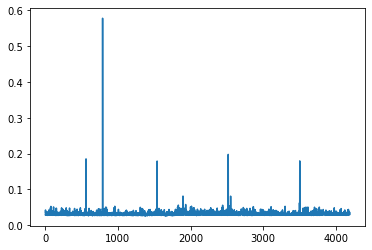

In [0]:
link = "http://prometheus-lts-data-science-on-the-moc-openshift.k-apps.osh.massopen.cloud"

pc = PrometheusConnect(url=link, disable_ssl=True)

start_time = parse_datetime("3d")
end_time = parse_datetime("now")
chunk_size = parse_timedelta("now", "1d")

metric1 = 'request_duration_seconds_count{app="jupyterhub",code="302",deployment="jupyterhub-7",deploymentconfig="jupyterhub",handler="jupyterhub.handlers.base.PrefixRedirectHandler",instance="10.128.5.199:8080",job="kubernetes-pods",kubernetes_namespace="data-science-on-the-moc-openshift",kubernetes_pod_name="jupyterhub-7-hd8d9",method="GET"}'
metric2 = 'scrape_duration_seconds{app="jupyterhub",deployment="jupyterhub-7",deploymentconfig="jupyterhub",instance="10.128.5.199:8080",job="kubernetes-pods",kubernetes_namespace="data-science-on-the-moc-openshift",kubernetes_pod_name="jupyterhub-7-hd8d9"}'

metric_data = pc.get_metric_range_data(
    metric2,
    start_time=start_time,
    end_time=end_time,
    chunk_size=chunk_size,
)

metrics_object_list = MetricsList(metric_data)
print(len(metrics_object_list))
for item in metrics_object_list:
    print(type(item))
    
for item in metrics_object_list:
    print(item.metric_name, item.label_config, "\n")
    
my_metric_object = metrics_object_list[0] # one of the metrics from the list

my_metric_object.metric_values['y'].plot()

### Building Model

#### Tuning Hyperparameters

In [0]:
number_of_features = 10
(train_x, train_y, test_x, test_y, scaler) = process_data(number_of_features, 0.8, my_metric_object.metric_values)

# Tuning Hyperparameters
bestSpecs = Specs()
for i in range(5, 8):
    LSTMCount = 2**i
    for j in range(5, 8):
        DenseCount = 2**j

        newSpecs = Specs(DenseCount, LSTMCount, 50)

        model, history = trainLSTM(newSpecs)
        val_loss = history.history['val_loss']
        loss = min(val_loss)

        if (loss < bestSpecs.loss):
            bestSpecs = newSpecs
            bestSpecs.loss = loss
            bestSpecs.epochs = val_loss.index(min(val_loss)) + 1
            print("New Results:", bestSpecs)

New Results: 32 32 38 4.38543799478924e-05
New Results: 32 64 12 4.377828998976145e-05


#### Training Final Model

Now training on 128 128 50 6.41665149178342e-07
Minimum Validation Loss is:5.319115320672024e-06
Epoch: 49


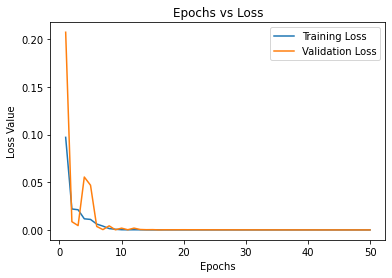

In [0]:
# Train final model
bestSpecs.epochs = 50
print("Now training on", bestSpecs)
finalmodel, history = trainLSTM(bestSpecs)
loss_curve(history)

### Testing Final Model

Results


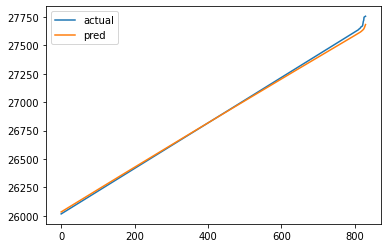

284.29205303903785


In [0]:
# Evaluate Test Predictions after training on metric 1
pred_t = finalmodel.predict(test_x)
pred_t_inverse = scaler.inverse_transform(pred_t)
test_y_inverse = scaler.inverse_transform(test_y.reshape(-1, 1))

print("Results")
plt.figure()
plt.plot(test_y_inverse, label = 'actual')
# plt.legend()
# plt.figure()
plt.plot(pred_t_inverse, label = 'pred')
plt.legend()
plt.show()

print(mse(pred_t_inverse, test_y_inverse))

Results




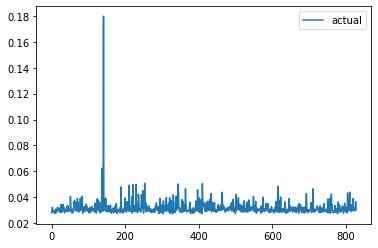

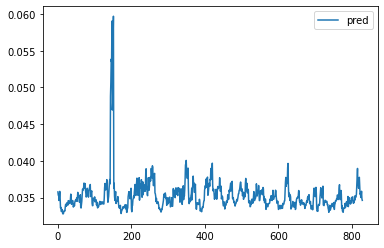

5.667958254778516e-05


In [0]:
# Evaluate Test Predictions after training on metric 2
pred_t = finalmodel.predict(test_x)
pred_t_inverse = scaler.inverse_transform(pred_t)
test_y_inverse = scaler.inverse_transform(test_y.reshape(-1, 1))

print("Results")
plt.figure()
plt.plot(test_y_inverse, label = 'actual')
plt.legend()
print('\n')
plt.figure()
plt.plot(pred_t_inverse, label = 'pred')
plt.legend()
plt.show()

print(mse(pred_t_inverse, test_y_inverse))